# This project is based on the a mini project from Springboard ML Career Track bootcamp. Some part of the code is directly taken from there. In Part 1 of the project we build a very basic movie recommender using a global method, which means the predictions of the movie ratings will be exactly the same for all users.

## Import dependencies

In [ ]:
!pip3 install pandas
!pip3 install sklearn
!pip3 install seaborn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pickle

# To store\load the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns


# To compute similarities between vectors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# To create deep learning models
import tensorflow as tf
import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To stack sparse matrices
from scipy.sparse import vstack
import gc

In [ ]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
# TF Version: 1.15.0
# Keras Version: 2.2.5

TF Version: 2.6.0
Keras Version: 2.6.0


## Load datasets

### load movie titles

In [ ]:
# Load data for all movies
movie_titles = pd.read_csv('movie_titles.csv',
                           encoding = 'ISO-8859-1', 
                           # we need header=None because the first row of the csv file is not header but actual data 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.head(5)

Shape Movie-Titles:	(17770, 2)


,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### load user-movie ratings

In [ ]:
# Load single data-file
df_raw_1 = pd.read_csv('combined_data_1.txt', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

df_raw_2 = pd.read_csv('combined_data_2.txt', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

df_raw = pd.concat([df_raw_1, df_raw_2])

del df_raw_1, df_raw_2
_=gc.collect()

df_raw_3 = pd.read_csv('combined_data_3.txt', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

df_raw = pd.concat([df_raw, df_raw_3])

del df_raw_3
_=gc.collect()

df_raw_4 = pd.read_csv('combined_data_4.txt', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

df_raw = pd.concat([df_raw, df_raw_4]).reset_index(drop=True)

del df_raw_4
_=gc.collect()

In [ ]:
df_raw.shape

(100498277, 3)

###  get the desired format

In [ ]:
# Find rows in the format of "1: NaN NaN" that label the start of a new movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index() # make the original index a new column
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and end row indices of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
print('Shape User-Ratings:\t{}'.format(df.shape))
display(df.sample(10))

del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id

Shape User-Ratings:	(100480507, 4)


,User,Rating,Date,Movie
89861726,2301123,4.0,2005-02-04,15956
96131834,2472682,3.0,2004-10-21,17031
96157500,775886,4.0,2004-09-02,17050
50893769,779137,5.0,2005-02-06,9189
55590160,973407,5.0,2004-08-20,10162
77958344,1368024,5.0,2005-05-01,14185
81281694,1676166,3.0,2002-04-07,14590
66253502,2170878,5.0,2004-05-12,12102
13396982,2256731,2.0,2004-10-30,2565
95819001,453098,5.0,2005-07-28,16977


## EDA

### movie release year

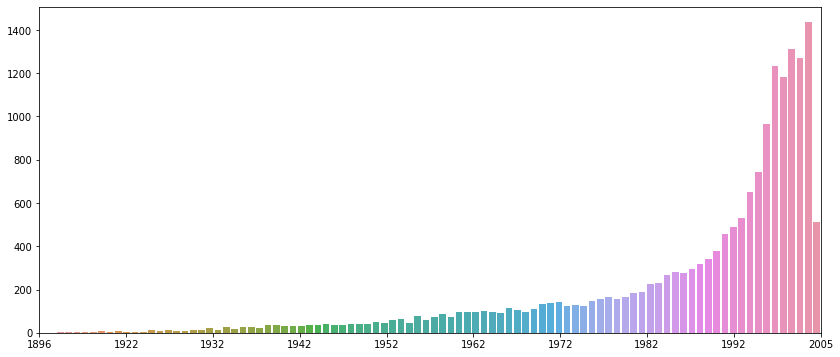

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

del fig, ax, data, x, y, xmin, xmax, xtick_labels

### distribution of ratings

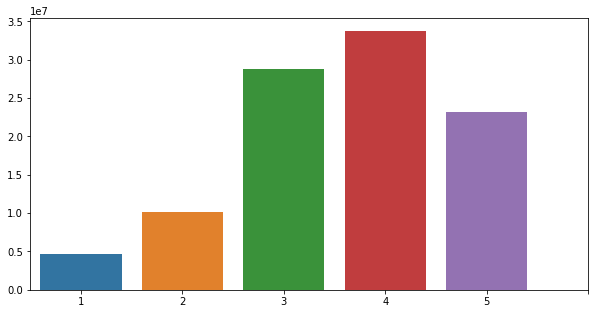

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

data = df['Rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
plt.xticks(ticks=[0,1,2,3,4,5]);

del fig, ax, data, x, y, xmin, xmax

**it seems that users tend to give good ratings**

### distribution of number of ratings movies receive

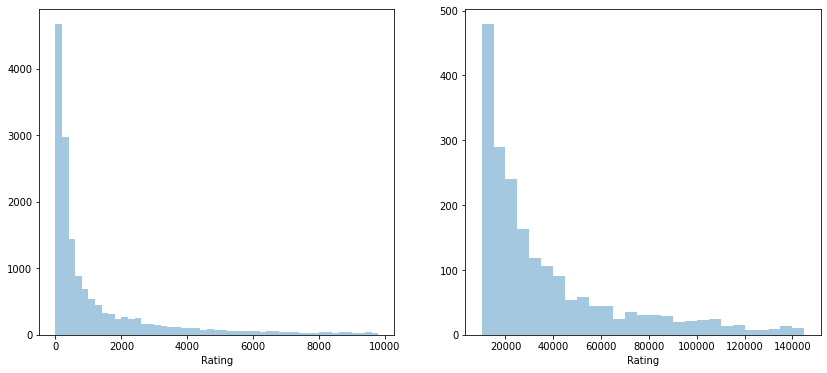

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0], bins=[i for i in range(0,10000,200)]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1], bins=[i for i in range(10000,150000,5000)]);

del fig, ax, data

**looks like exponential decay**

## distribution of ratings users give

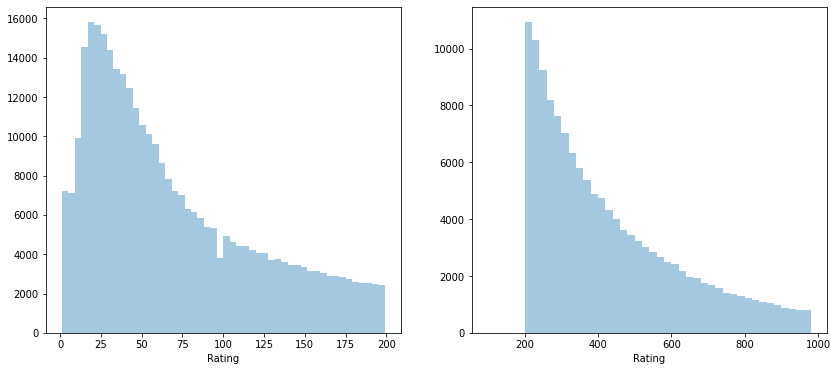

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('User')['Rating'].count()
sns.distplot(data[data  < 200], kde=False, ax=ax[0]);
sns.distplot(data[data  > 200], kde=False, ax=ax[1], bins=[i for i in range(100,1000,20)]);

del fig, ax, data

**also looks like exponential decay**

## Filter out rarely rated movies and users who don't give enough ratings

In [ ]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filtered = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]

print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filtered.shape))

del df, filter_movies, filter_users, min_movie_ratings, min_user_ratings

Shape User-Ratings unfiltered:	(100480507, 4)
Shape User-Ratings filtered:	(75010415, 4)


## split train, cross validation and test sets

In [ ]:
df_filtered = df_filtered.drop('Date', axis=1).sample(frac=1, random_state=7).reset_index(drop=True)

# splits
split3 = df_filtered.shape[0]-1000000
split2 = split3-100000
split1 = split2-100000

# Split train, val & test sets
df_train = df_filtered[:split1]
df_val = df_filtered[split1:split2]
df_test = df_filtered[split2:split3]
df_stacking = df_filtered[split3:]

# don't delete df_filtered yet

In [ ]:
df_train.shape, df_val.shape, df_test.shape, df_stacking.shape

### check if all users are included in the training set

In [ ]:
df_filtered['User'].unique().shape[0], df_train['User'].unique().shape[0]

(150245, 150245)

### check if all movies are included in the training set

In [ ]:
df_filtered['Movie'].unique().shape[0], df_train['Movie'].unique().shape[0]

(7125, 7125)

**delete df_filtered now to save memory**

In [ ]:
del df_filtered
_=gc.collect()

## global recommender system using weighted rating

Weighted Rating Formula

weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

where:

𝑅 = average for the movie (mean) = (Rating)

𝑣 = number of votes for the movie = (votes)

𝑚 = minimum votes required

𝐶 = the mean vote across the whole report

In [ ]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_train['Rating'].mean()

# Mean rating for all movies separately
R = df_train.groupby(['Movie']).mean()['Rating'].values

# Rating freqency for all movies separately
v = df_train.groupby(['Movie']).count()['Rating'].values

In [ ]:
# Weighted formula to compute the weighted rating
weighted_score = v/(v+m)*R+m/(v+m)*C
del m, C, R, v
_=gc.collect()

In [ ]:
# convert weighted_score into a dataframe
index=np.sort(df_train['Movie'].unique())
weighted_mean = pd.DataFrame(weighted_score, index = index, columns = ['weighted score'])
weighted_mean.index.name = 'Id'
display(weighted_mean.head(5))

del index, weighted_score

,weighted score
Id,
3,3.606174
5,3.697078
6,3.380697
8,3.182964
16,3.231614


In [ ]:
# Combine the aggregated dataframes (wighted_mean & movie_titles)
combined_df = weighted_mean.join(movie_titles)
print(weighted_mean.shape)
print(movie_titles.shape)
print(combined_df.shape)
display(combined_df.head(5))

del weighted_mean

(7125, 1)
(17770, 2)
(7125, 3)


,weighted score,Year,Name
Id,,,
3,3.606174,1997.0,Character
5,3.697078,2004.0,The Rise and Fall of ECW
6,3.380697,1997.0,Sick
8,3.182964,2004.0,What the #$*! Do We Know!?
16,3.231614,1996.0,Screamers


### evaluation RMSE and MAE

In [ ]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(combined_df)
predictions_df.head(5)

,User,Rating,weighted score,Year,Name
6,404378,5.0,3.380697,1997.0,Sick
8,2570542,5.0,3.182964,2004.0,What the #$*! Do We Know!?
8,2005193,4.0,3.182964,2004.0,What the #$*! Do We Know!?
8,162279,5.0,3.182964,2004.0,What the #$*! Do We Know!?
8,2148613,4.0,3.182964,2004.0,What the #$*! Do We Know!?


In [ ]:
# Compute RMSE and MAE
y_true = predictions_df['Rating']
y_pred = predictions_df['weighted score']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
print("The RMSE Value for the Mean Rating Recommender:", rmse)
print("The MAE Value for the Mean Rating Recommender:", mae)

del predictions_df, y_true, y_pred, rmse, mae

The RMSE Value for the Mean Rating Recommender: 0.9917835737069347
The MAE Value for the Mean Rating Recommender: 0.7980064023152397


### at this stage, non-deleted variables are: df_train, df_val, df_test, combined_df

### evaluation mean average precision at cutoff k

**first define an ordered dict that stores movie id and weighted average movie score from high to low**

In [ ]:
from collections import OrderedDict
temp=combined_df.reset_index()[['Id','weighted score']].sort_values('weighted score', ascending=False)

# {movie_id: weighted_score, ....}
rank_dic=OrderedDict()
for i in range(temp.shape[0]):
    rank_dic[temp.iloc[i,0]]=temp.iloc[i,1]

del temp

**define the function that calculates map@k**

In [ ]:
def average_precision_at_k(rel: [int], pred: [int], k: int) -> float:
    # this function works only for a single user
    # rel is an list of movie id's for all relevant movies in the test set 
    # pred is the prediction of the model excluding those ratings already in the training set
    # pred is a list of movie id's whose scores are ranked from high to low
    # len(pred) should be large enough for k
    # k is the cutoff
    temp=0
    true_positive=0
    for i in range(min(k,len(pred))):
        if pred[i] in rel:
            true_positive+=1
            temp+=true_positive/(i+1)
    return temp/len(rel)

**list of unique users in the test**

In [ ]:
test_user_ids={}
for ele in list(df_test['User'].unique()):
    test_user_ids[ele]=True

**create dictionaries that store movie id's and the average ratings of users in the train set**

In [ ]:
# {user_id: [movie_id_1, movie_id_2, ...], ...}
train_movie_ids={}
# {user_id: average_rating, ...}
train_movie_average_ratings={}
ct=0

for i in range(df_train.shape[0]):
    if i % (df_train.shape[0]//100)==0: 
        print(str(ct)+' percent of job done')
        ct+=1
        
    user = df_train.iloc[i, 0]
    if user in test_user_ids:
        try:
            train_movie_ids[user].append(df_train.iloc[i,2])
            train_movie_average_ratings[user]+=df_train.iloc[i,1]
        except:
            train_movie_ids[user]=[df_train.iloc[i,2]]
            train_movie_average_ratings[user]=df_train.iloc[i,1]

del user

0 percent of job done
1 percent of job done
2 percent of job done
3 percent of job done
4 percent of job done
5 percent of job done
6 percent of job done
7 percent of job done
8 percent of job done
9 percent of job done
10 percent of job done
11 percent of job done
12 percent of job done
13 percent of job done
14 percent of job done
15 percent of job done
16 percent of job done
17 percent of job done
18 percent of job done
19 percent of job done
20 percent of job done
21 percent of job done
22 percent of job done
23 percent of job done
24 percent of job done
25 percent of job done
26 percent of job done
27 percent of job done
28 percent of job done
29 percent of job done
30 percent of job done
31 percent of job done
32 percent of job done
33 percent of job done
34 percent of job done
35 percent of job done
36 percent of job done
37 percent of job done
38 percent of job done
39 percent of job done
40 percent of job done
41 percent of job done
42 percent of job done
43 percent of job don

**divide the sum of ratings by the number of movies to get average rating for each user**

In [ ]:
for key in test_user_ids:
    train_movie_average_ratings[key]/=len(train_movie_ids[key])

**test_movie_ids is a dicitionary that stores positively rated movies in the test sets for each user in the test sets**

In [ ]:
# {user_id: [movie_id_1, movie_id_2, ...], ...}
test_movie_ids={}

for i in range(df_test.shape[0]):
    user=df_test.iloc[i,0]
    if df_test.iloc[i,1]>train_movie_average_ratings[user]:
        try:
            test_movie_ids[user].append(df_test.iloc[i,2])
        except:
            test_movie_ids[user]=[df_test.iloc[i,2]]

**loop through all users in test set and apply the function we defined**

In [ ]:
# result stores average precision at k for users in test set
result=[]
k=100

for user in test_movie_ids:
    
    rel=test_movie_ids[user]
    copy_dic=rank_dic.copy()
    for ele in train_movie_ids[user]:
        copy_dic.pop(ele)
    pred=list(copy_dic.keys())
    result.append(average_precision_at_k(rel, pred, k))

In [ ]:
print('there are {} users in the test set'.format(len(test_user_ids)))
print('there are {} users whose ratings in the test set are all negative'.format(len(test_user_ids)-len(test_movie_ids)))
print('mean average precision is {}'.format(sum(result)/len(result)))

there are 66852 users in the test set
there are 24851 users whose ratings in the test set are all negative
mean average precision is 0.013133213156647231


###  at this stage, non-deleted variables are: 
### df_train, df_val, df_test, combined_df
### test_user_ids, test_movie_ids, train_movie_ids, train_movie_average_ratings

In [ ]:
df_train.to_pickle('df_train.pkl')
df_val.to_pickle('df_val.pkl')
df_test.to_pickle('df_test.pkl')
df_stacking.to_pickle('df_stacking.pkl')
combined_df.to_pickle('combined_df.pkl')

In [ ]:
test_user_ids_list=list(test_user_ids.keys())

with open('test_user_ids_list.txt', 'wb') as fp:
    pickle.dump(test_user_ids_list, fp)

In [ ]:
test_movie_ids_list=[]
for key in test_movie_ids:
    test_movie_ids_list.append([key, test_movie_ids[key]])
    
with open('test_movie_ids_list.txt', 'wb') as fp:
    pickle.dump(test_movie_ids_list, fp)

In [ ]:
train_movie_ids_list=[]
for key in train_movie_ids:
    train_movie_ids_list.append([key, train_movie_ids[key]])
    
with open('train_movie_ids_list.txt', 'wb') as fp:
    pickle.dump(train_movie_ids_list, fp)

In [ ]:
train_movie_average_ratings_list=[]
for key in train_movie_average_ratings:
    train_movie_average_ratings_list.append([key, train_movie_average_ratings[key]])
    
with open('train_movie_average_ratings_list.txt', 'wb') as fp:
    pickle.dump(train_movie_average_ratings_list, fp)